In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from ipynb.fs.full.functions import add_labels

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

save_figures = False

# Model Uncertainty

1. Model error - linear elasticity
2. Input error - noise in the strain
3. Output error - noise in the experimental observations (stress)

## Likelihood

### Statistical generating model

No model is completely correct and model uncertainty as an error source can be incorporated. A framework able to do so was developed by Kennedy and O'Hagan [[1]( https://doi.org/10.1111/1467-9868.00294)]

$$\sigma_{observed} = \sigma_{true} + \Omega$$

with

$$\sigma_{true} = \sigma_{model}(\epsilon, \textbf{x}) + d(\epsilon)$$

$$\therefore \; \sigma_{observed} =  \sigma_{model}(\epsilon, \textbf{x}) + d(\epsilon) + \Omega$$

where $\Omega$ is the error in the stress measurement and $d$ denotes the model uncertainty which is assumed to be dependent on the input (i.e. strain $\epsilon$).

The likelihood...

$$\pi(y|\textbf{x}, \textbf{x}_d, \textbf{x}_{\Omega}) = \pi_{\Omega}(y - \sigma_{model}(\epsilon, \textbf{x}) - d(\epsilon))$$

where $\textbf{x}_d$ denotes the parameter vector of the model uncertainty and $\textbf{x}_{\Omega}$ represents the parameters in the noise distribution of the experimental observations (stress). The distribution of the noise in the experimental observations is assumed to be Gaussian with a variance $s_{noise}^2$ and zero mean.

In [2]:
def material_model(epsilon, E=210):
    """
    Linear elastic material model
    """
    return epsilon * E

In [3]:
def true_process(epsilon, E=210, alpha=0.015):
    return (epsilon * E) / (1 + (epsilon / alpha))

In [4]:
def generate_synthetic_data(x, n_data_points, func, s_noise=0.01, seed=None):
    np.random.seed(seed)
    x_subset = np.random.choice(x, n_data_points)
    y = np.zeros(n_data_points)

    for i in range(n_data_points):
        y[i] = func(x_subset[i]) + (s_noise * np.random.normal())

    return x_subset, y

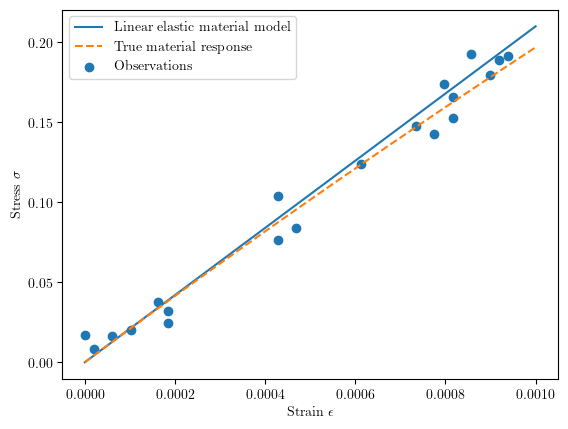

In [5]:
x = np.linspace(0, 1e-3)
model = material_model(x)
true = true_process(x)
strain_data, stress_data = generate_synthetic_data(
    np.linspace(0, 1e-3), 20, true_process, s_noise=0.01, seed=4
)

plt.plot(x, model, label="Linear elastic material model")
plt.plot(x, true, label="True material response", linestyle="--")
plt.scatter(strain_data, stress_data, label="Observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend();

## Inference

In [6]:
def prior_distribution(x, mean, std_dev):
    return np.exp(-((x - mean) ** 2 / (2 * std_dev**2)))

In [7]:
def set_prior(pi, mean, std_dev):
    def wrapper(x):
        return pi(x, mean, std_dev)

    return wrapper

In [8]:
def likelihood_distribution(omega, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (omega**2 / sigma**2))

In [9]:
def calculate_omega(observation, model):
    return observation - model

In [10]:
def set_likelihood(pi, sigma, observations, x):
    def wrapper(candidate):
        omega = 0
        for i in range(len(x)):
            omega += calculate_omega(observations[i], material_model(candidate, x[i]))
        return pi(omega, sigma)

    return wrapper

In [11]:
def calc_posterior(prior, likelihood):
    return prior * likelihood

In [12]:
def set_posterior(calc_prior, calc_likelihood, observations, x):
    def wrapper(candidate):
        return calc_posterior(calc_prior(candidate), calc_likelihood(candidate))

    return wrapper

In [13]:
def mh_sampler(pi, steps=3000, step_size=5, init=0):
    """
    Metropolis-Hastings sampler with a normal proposal
    """
    point = init
    samples = []
    pdf = []
    for _ in range(int(steps)):
        proposal = np.random.normal(point, step_size)
        if np.random.rand() < pi(proposal) / pi(point):
            point = proposal
        samples.append(point)
        pdf.append(pi(point))
    return np.array(samples), np.array(pdf)

/var/folders/_9/zklm8t655ss6fnsdt5s12hv40000gq/T/ipykernel_43891/3737500982.py:10: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() < pi(proposal) / pi(point):
/var/folders/_9/zklm8t655ss6fnsdt5s12hv40000gq/T/ipykernel_43891/3737500982.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  if np.random.rand() < pi(proposal) / pi(point):


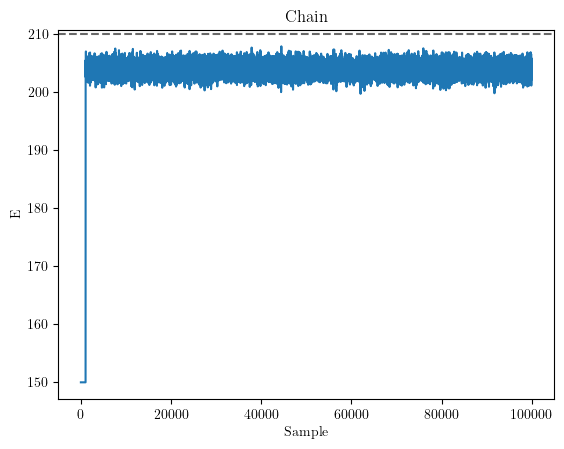

In [14]:
prior = set_prior(prior_distribution, 150, 50)
likelihood = set_likelihood(likelihood_distribution, 0.01, stress_data, strain_data)

samples, pdf = mh_sampler(
    set_posterior(prior, likelihood, stress_data, strain_data),
    steps=1e5,
    step_size=5,
    init=150,
)
plt.plot(samples)
plt.axhline(210, ls="--", color="dimgray")
add_labels("Chain", "Sample", "E")

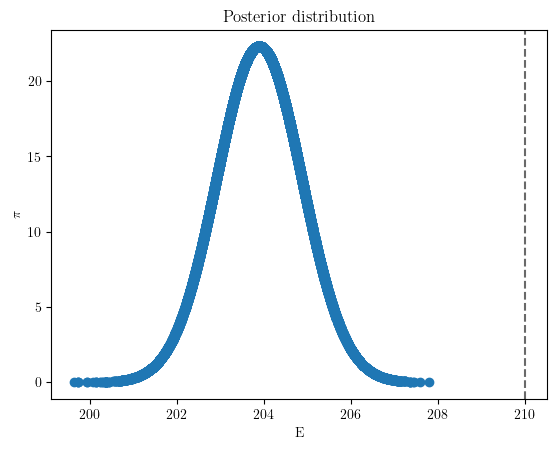

In [17]:
plt.scatter(samples[2000:], pdf[2000:])
plt.axvline(210, ls="--", color="dimgray")
add_labels("Posterior distribution", "E", "$\pi$")

## Gaussian process with a stationary covariance function

The model uncertainty is described as a Gaussian process with a zero mean and stationary covariance function. 

$$d \sim \mathcal{GP}(0, \lambda^2(., . | \psi))$$

where $c$ is the squared exponential correlation function

$$c(\epsilon_i, \epsilon_j | \psi) = exp\left(-\frac{(\epsilon_i - \epsilon_j)^2}{2\psi^2}\right)$$

where $\lambda^2$ denotes the variance and $\psi$ the length scale, yielding $\textbf{x}_d = [\lambda  \quad \psi]^T$.

The likelihood function is:

$$\pi(\textbf{y}|\textbf{x}, \textbf{x}_d) = \mathcal{N}(\sigma(\mathbf{\epsilon}, \textbf{x}), \Gamma_{GP} + s_{noise}^2\textbf{I}_{n_m})$$

where

$$\Gamma_{GP} = 
\begin{bmatrix} 
\lambda^2 c (\epsilon_1, \epsilon_1 | \psi) & \dots & \lambda^2 c (\epsilon_1, \epsilon_{n_m} | \psi) \\
\vdots & \ddots & \vdots \\
\lambda^2 c (\epsilon_{n_m}, \epsilon_1 | \psi) & \dots & \lambda^2 c (\epsilon_{n_m}, \epsilon_{n_m} | \psi)
\end{bmatrix}$$

We consider the following prior distributions for the model parameters $\textbf{x}_d = [\lambda  \quad \psi]^T$.




## References

[1] Kennedy, M. C., & O'Hagan, A. (2001). Bayesian calibration of computer models. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 63(3), 425-464.